In [1]:
import sys
sys.path.append('/n/home09/kboone/scattering_transform/')
import scattering

import os
import torch
import skyproj
import numpy as np
import healpy as hp
from patchify import *
import healsparse as hsp
import matplotlib.pyplot as plt

use torch backend


In [2]:
int(np.log2(256)) - 1

7

In [3]:
def ell(j, pix=3.44):
    # pix is the size in arcminutes
    return (3*np.pi/(2**(j+2))) / pix * 60 * 180 / np.pi

In [8]:
ell(6)

36.79142441860465

In [11]:
np.sqrt(4*np.pi/(12*1024**2))

0.0009993424882289927

In [3]:
Om = 0.3175
d_Om = 0.01

s8 = 0.834
d_s8 = 0.015

In [4]:
kyle_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/'
mask_dir = kyle_dir + 'masks/'

nside = 1024
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios/'

mask_files = os.listdir(mask_dir)
surveys = [mask_file.rstrip("npy") for mask_file in mask_files]
surveys = [survey.rstrip(".") for survey in surveys]

mask_maps = []
for survey in surveys:
    mask_maps.append(np.load(mask_dir + survey + '.npy'))

In [5]:
surveys[0:4]

['ACT', 'Planck', 'SO', 'SPT']

In [6]:
len(mask_maps)

6

In [7]:
surveys

['ACT', 'Planck', 'SO', 'SPT', 'SPT_main', 'SPT_summer']

## Generate Weight Maps for Patches

In [8]:
# patch_inds = np.load('Data/Patches/patches_nside_1024.npy')
# coords = np.load('Data/Patches/coords_nside_1024.npy')
# unmask = patch_inds > -0.5

In [9]:
# ind = 3
# survey_mask = mask_maps[ind] + 1

# patches = np.zeros_like(patch_inds)
# patches[unmask] = np.take(survey_mask, patch_inds[unmask])

In [10]:
# counts = []
# for i in np.arange(len(patches)):
#     counts.append(len(np.where(patches[i] > 1.5)[0]))#/len(np.where(patches[i] > 0.5)[0])) this is for weights
# counts = np.array(counts)
# # counts[np.where(weights<0.2)[0]] = 0

# np.save('Data/Patches/counts_' + surveys[ind] + '.npy', counts)

In [11]:
# plot_patches(patches, coords, nrows=3, ncols=3, start_idx=0)

## Look at Patches

In [12]:
all_files = np.array(os.listdir(conv_dir))
fid_inds = [i for i, s in enumerate(all_files) if s.startswith('f')]
Om_inds = [i for i, s in enumerate(all_files) if s.startswith('O')]
s8_inds = [i for i, s in enumerate(all_files) if s.startswith('s')]

fid_files = all_files[fid_inds]
Om_files = all_files[Om_inds]
s8_files = all_files[s8_inds]

In [13]:
len(all_files)

1302

In [14]:
len(os.listdir('/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/wst_j6_l4/'))

1302

In [15]:
def file_num(s):
    # Find the index of the first '_'
    start = s.find('_')
    
    # Find the index of the first '.' after the '_'
    end = s.find('.', start)
    
    # Extract and return the substring between '_' and '.'
    return s[start + 1:end]

In [16]:
file_num(Om_files[1])

'0_flipped'

In [17]:
ind = 1
survey_mask = mask_maps[ind]
survey_map = np.copy(np.load(conv_dir+Om_files[-1], allow_pickle='True')[0][surveys[ind]])
survey_map[np.where(survey_mask < .5)] = 0

In [20]:
weights = np.load('../Data/Patches/weights_' + surveys[ind] + '.npy')
patch_inds = np.load('../Data/Patches/patches_nside_1024.npy')[np.where(weights>0)]
coords = np.load('../Data/Patches/coords_nside_1024.npy')[np.where(weights>0)]
weights = weights[np.where(weights>0)]
unmask = patch_inds > -0.5

In [21]:
np.min(weights)

0.20809494826536823

In [6]:
patches = np.zeros_like(patch_inds).astype(float)
patches[unmask] = np.take(survey_map, patch_inds[unmask])

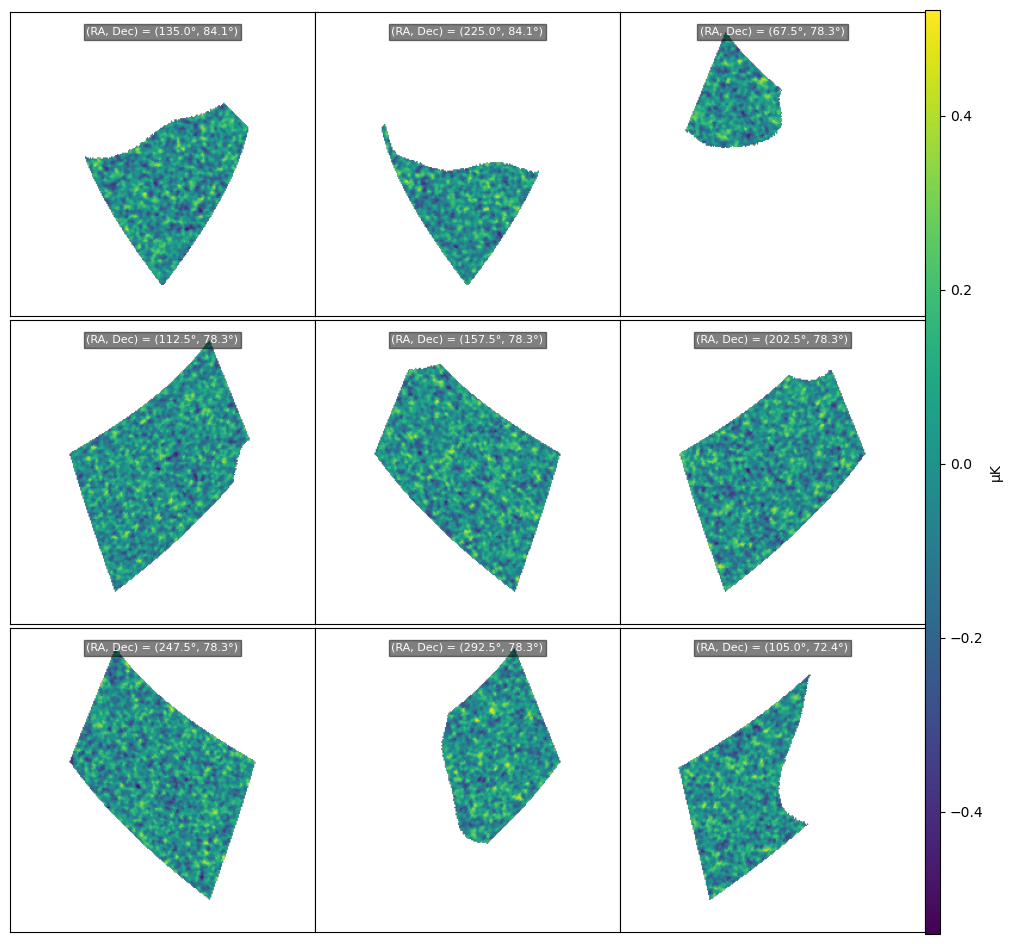

In [34]:
plot_patches(patches, coords, nrows=3, ncols=3, start_idx=0)

In [7]:
num = 10
imgs = patches[0:num]
J=6
L=4

st_calc = scattering.Scattering2d(M=256, N=256, J=J, L=L, device='cpu')

In [8]:
s_mean = st_calc.scattering_coef_simple(np.array([imgs[0]]))

M1256
torch.Size([1, 4, 256, 256])
M1256
torch.Size([1, 4, 256, 256])
M1128
torch.Size([1, 4, 128, 128])
M164
torch.Size([1, 4, 64, 64])
M132
torch.Size([1, 4, 32, 32])
M116
torch.Size([1, 4, 16, 16])


In [37]:
S0 = np.array(s_mean['S0'])
S1 = np.array(s_mean['S1_iso'])

In [38]:
S2 = np.atleast_2d(np.array(s_mean['S2_iso']).flatten())
crop = ~np.isnan(S2[0])
S2 = S2[:,crop]

In [36]:
coeffs = np.append(S0, np.append(S1, S2, axis=1), axis=1)

In [23]:
S0 = np.array(s_mean['S0'])
S1 = np.array(s_mean['S1_iso'])
S2 = np.average(np.array(s_mean['S2_iso']), axis = 3)
S2 = S2.reshape(1, J**2)
crop = ~np.isnan(S2[0])
S2 = S2[:,crop]

coeffs = np.append(S0, np.append(S1, S2, axis=1), axis=1)

In [24]:
np.sum(coeffs, axis = 0)

array([-0.00138255,  0.00345695,  0.005311  ,  0.00537318,  0.0036353 ,
        0.00217996,  0.00151687,  0.00042668,  0.00047979,  0.00044451,
        0.00042906,  0.00056924,  0.00104113,  0.00065647,  0.0007811 ,
        0.00074602,  0.00091049,  0.00161163,  0.00071905,  0.00086148,
        0.00100067,  0.00161989,  0.00055948,  0.00076429,  0.00111454,
        0.0003979 ,  0.0006277 ,  0.00033887])

# IMPORTANT

The above is my data vector I want to be storing for each one in theory.

## Seeing Where Pixels Get Lost

In [17]:
# patch = 367
# map_8 = np.zeros(len(patches))
# map_8[patch] = 1
# map_1024 = hp.pixelfunc.ud_grade(map_8, nside)
# map_1024[np.where(map_1024<0.5)] = hp.UNSEEN

# unmask_ind = np.where(map_1024>0)[0]
# map_1024[unmask_ind[~np.isin(unmask_ind, patch_inds[patch])]] = 0

# inds, counts = np.unique(patch_inds[patch], return_counts = True)
# inds = inds[1:]
# counts = counts[1:]

# dupli = inds[np.where(counts>1.5)]
# counts_dupli = counts[np.where(counts>1.5)]

# map_1024[dupli] = counts_dupli

# nest_1024 = hp.reorder(map_1024, inp='RING', out='NEST')

In [18]:
# nside_coverage = 32
# hsp_map = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=nest_1024)

In [19]:
# fig = plt.figure(1, figsize=(10, 8))
# ax = fig.add_subplot(111)
# sp = skyproj.McBrydeSkyproj(ax=ax)
# sp.draw_hspmap(hsp_map, cmap = 'gray_r')
# plt.colorbar(location = 'bottom', label = 'Number of Appearances in Patch', fraction = 0.039)
# #fig.suptitle(r'$r\leq 24.5$', y = 1)
# plt.show()